In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [55]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
if 'vehicle' not in zinc.columns:
    zinc['vehicle'] = 'wheat flour'
vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin_a'
if 'vehicle' not in vitamin_a.columns:
    vitamin_a['vehicle'] = 'oil'
iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_u5.columns if 'draw' not in c])).reset_index()

results = pd.concat([zinc, vitamin_a, iron], ignore_index=True)
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
results['label'] = np.where(results['vehicle'] == np.nan, results['nutrient_name'], 
                            results['nutrient_name'] + ' in ' + results['vehicle'])

l = get_ids('location')
results = results.merge(l, on='location_id')
results.head()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,location_id,measure,nutrient,vehicle,year,nutrient_name,label,location_name,location_type,location_description
0,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,161,pif,zinc,wheat flour,2021,Zinc,Zinc in wheat flour,Bangladesh,admin0,admin0
1,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,161,pif,zinc,wheat flour,2021,Zinc,Zinc in wheat flour,Bangladesh,admin0,admin0
2,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,161,pif,zinc,wheat flour,2021,Zinc,Zinc in wheat flour,Bangladesh,admin0,admin0
3,0.2,2.282822,5.154171,4.313578,4.942925,4.147101,3.725600,5.981238,4.465086,4.508418,...,161,pif,zinc,wheat flour,2022,Zinc,Zinc in wheat flour,Bangladesh,admin0,admin0
4,0.5,5.778294,13.046272,10.918558,12.511564,10.497171,9.430264,15.139750,11.302055,11.411738,...,161,pif,zinc,wheat flour,2022,Zinc,Zinc in wheat flour,Bangladesh,admin0,admin0


In [63]:
coverage_levels = [0.2,0.5,0.8]

def make_location_specific_plots(data, location_id, measure, coverage_levels):
    data_loc = (data
                .loc[data.location_id==location_id]
                .loc[data.year==2025]
                .loc[data.measure == measure]
                .sort_values(by=['nutrient','vehicle']))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    nutrient_spacer = 0.15
    coverage_spacer = 0.025
    data_loc = (data_loc.set_index([c for c in data_loc.columns if 'draw' not in c])
                .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())
    
    for n in list(range(0, len(coverage_levels))):
        df = (data_loc.loc[data_loc.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(df))):
            plt.plot([nutrient_spacer * i + coverage_spacer * n, nutrient_spacer * i + coverage_spacer * n],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['97.5%'].values[i], s=50, marker='_',
                        c='black')
            
        x_vals = []
        for x in list(range(0, len(df))):
            x_vals.append(nutrient_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, df['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               nutrient_spacer * (len(df)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    l_name = data_loc.location_name.values[0]

    if measure == 'rates_averted':
        plt.title(f'DALYs Averted per 100,000 Person-Years in {l_name} by Nutrient')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'DALYs Averted in {l_name} by Nutrient')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'Population Impact Fractions in {l_name} by Nutrient\nDALYs Averted as a Fraction of DALYs Attributable to Respective Nutrient Deficiencies')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    plt.xticks(rotation=45)
    ax.set_xticklabels(df.reset_index().label.unique())
    plt.savefig(f'results_plots/by_location/{l_name}_{measure}.png', bbox_inches='tight')

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


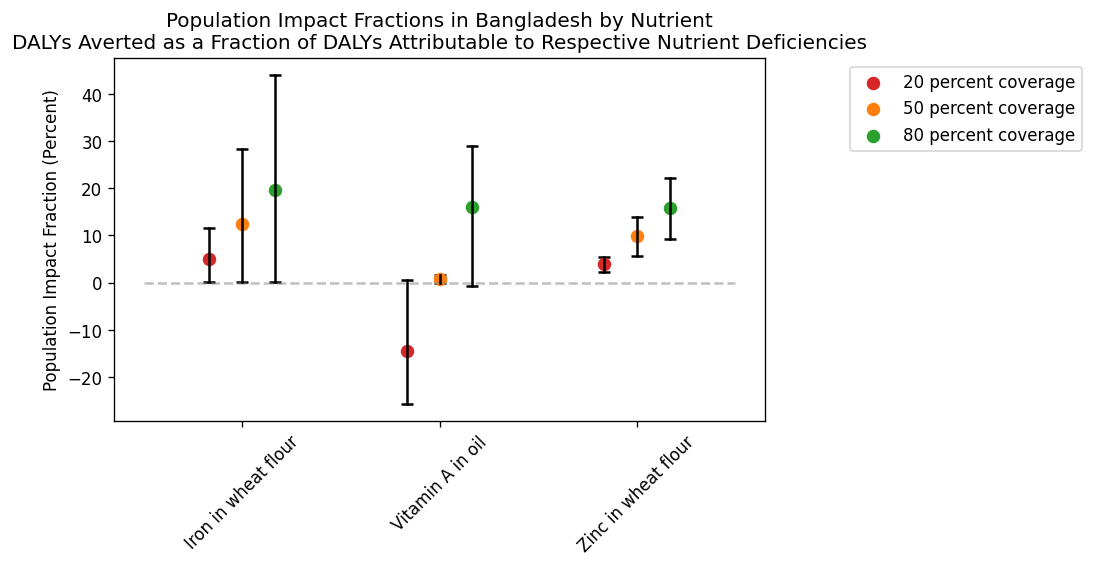

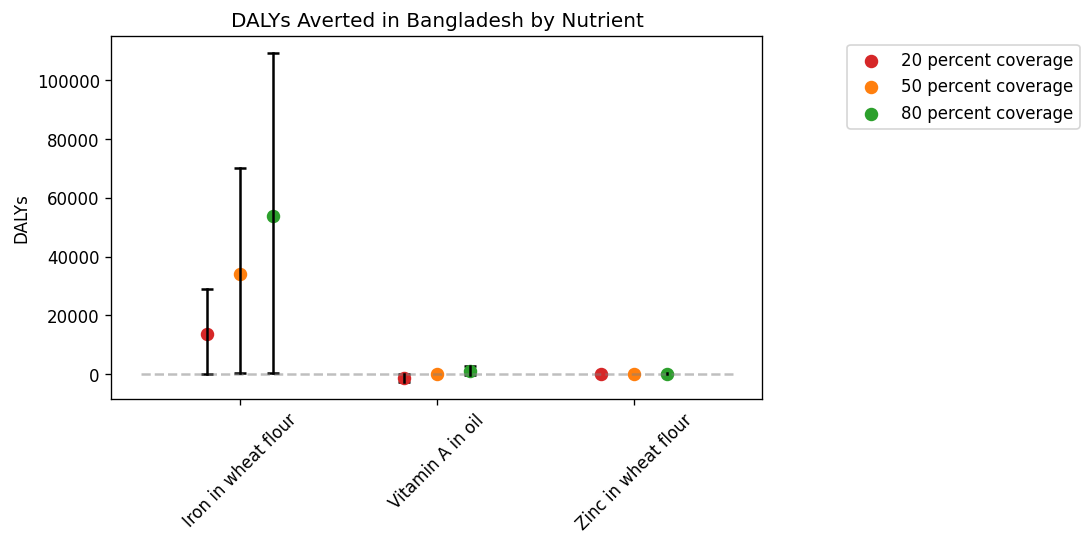

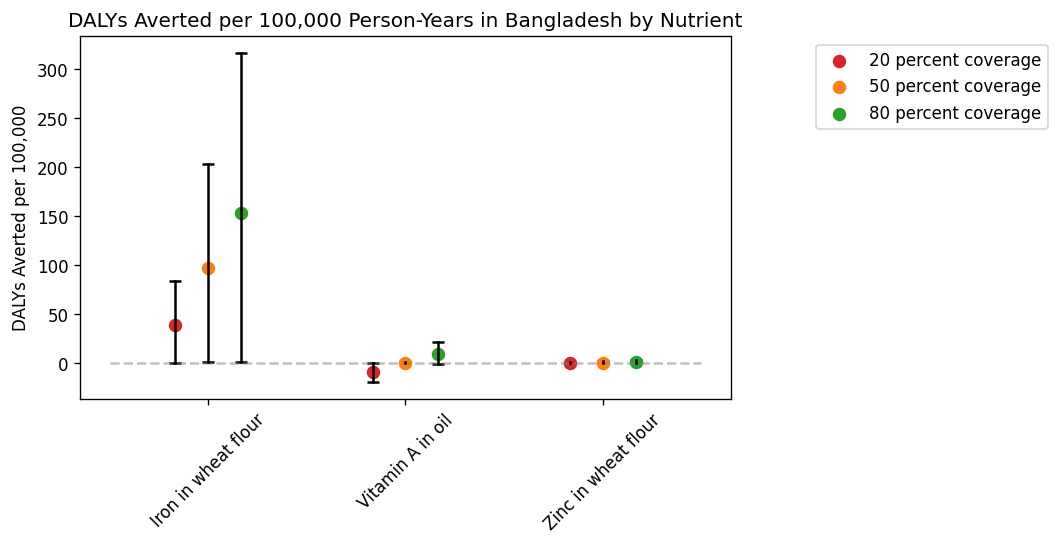

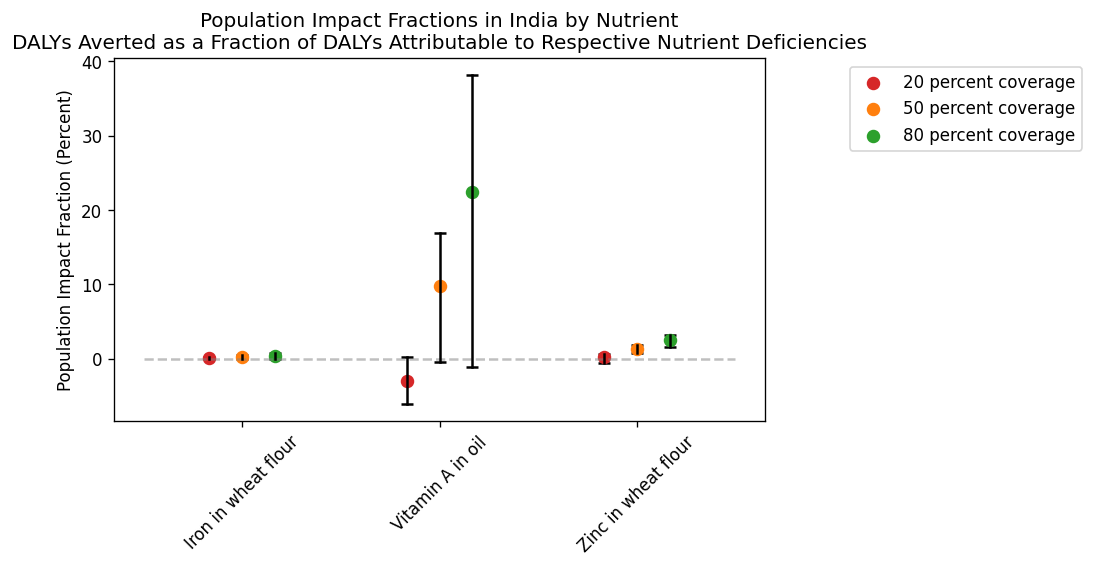

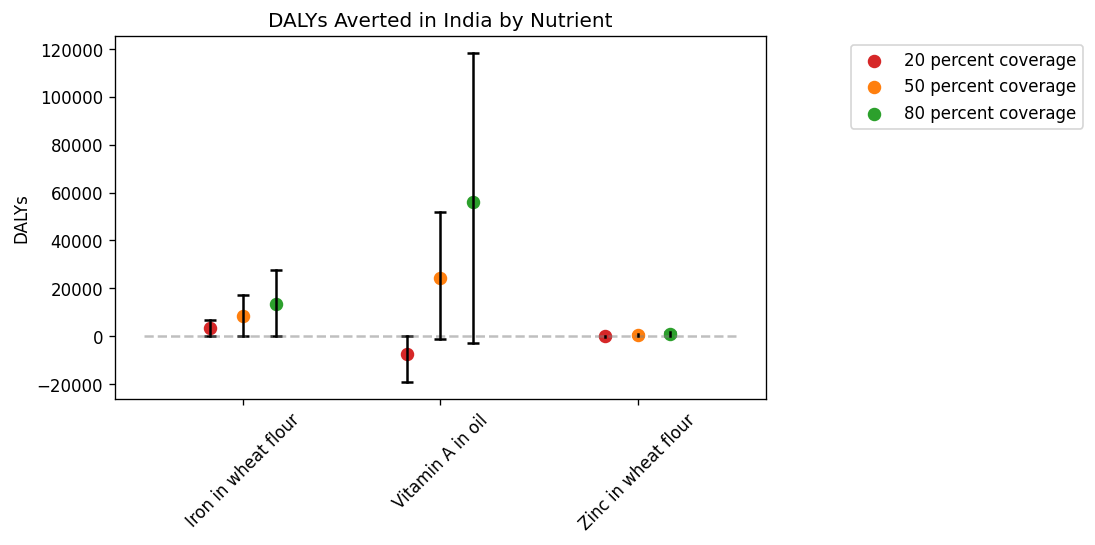

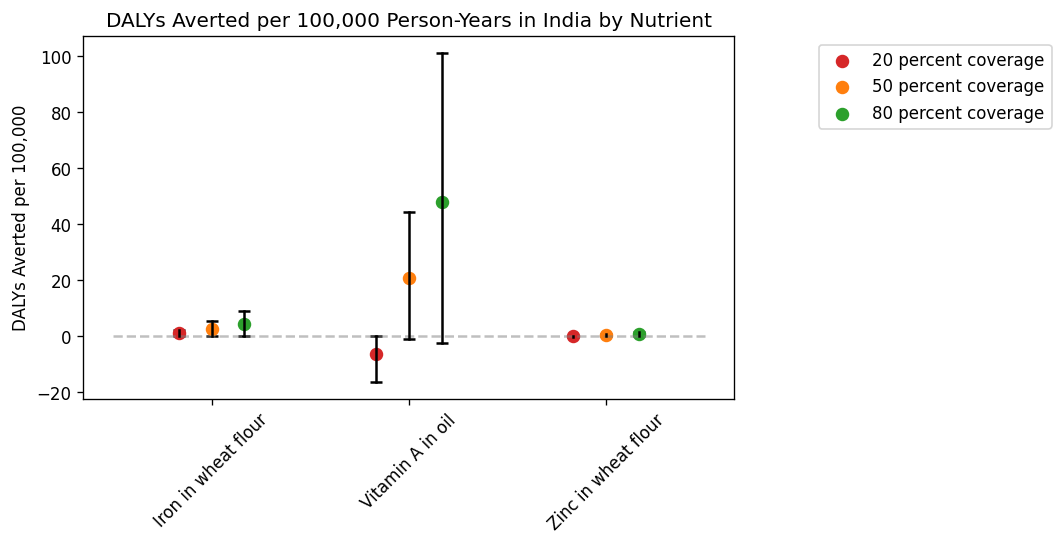

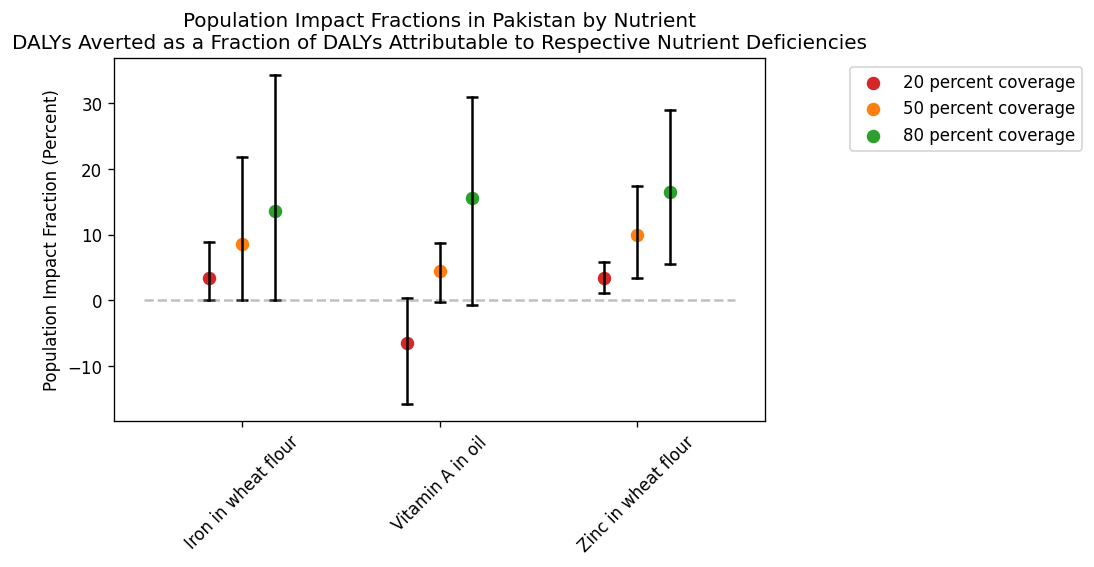

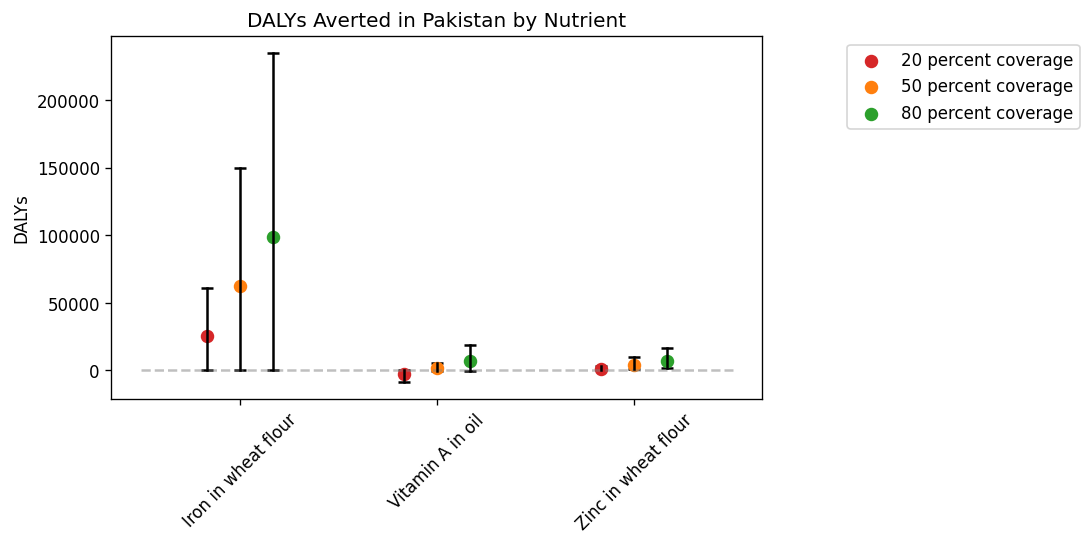

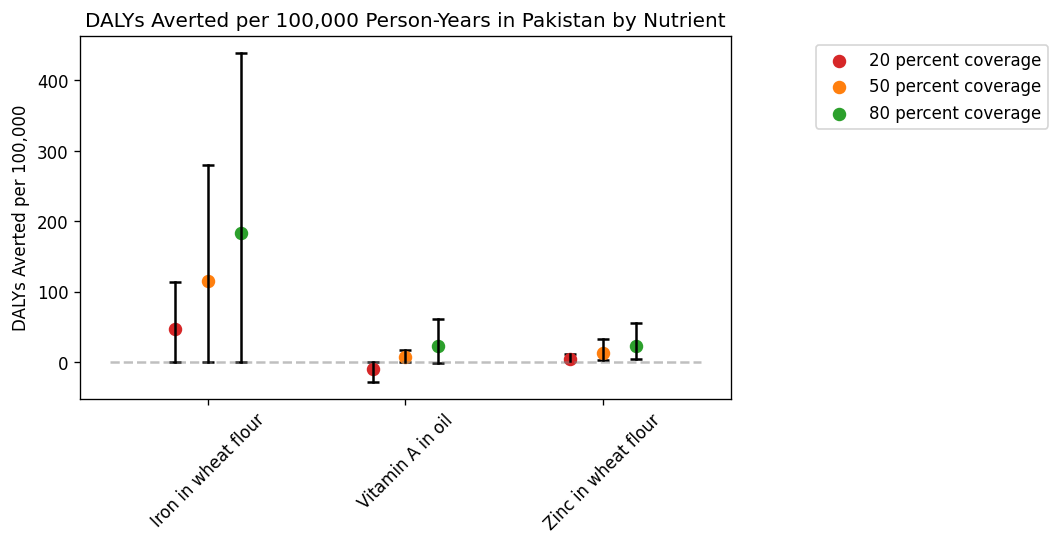

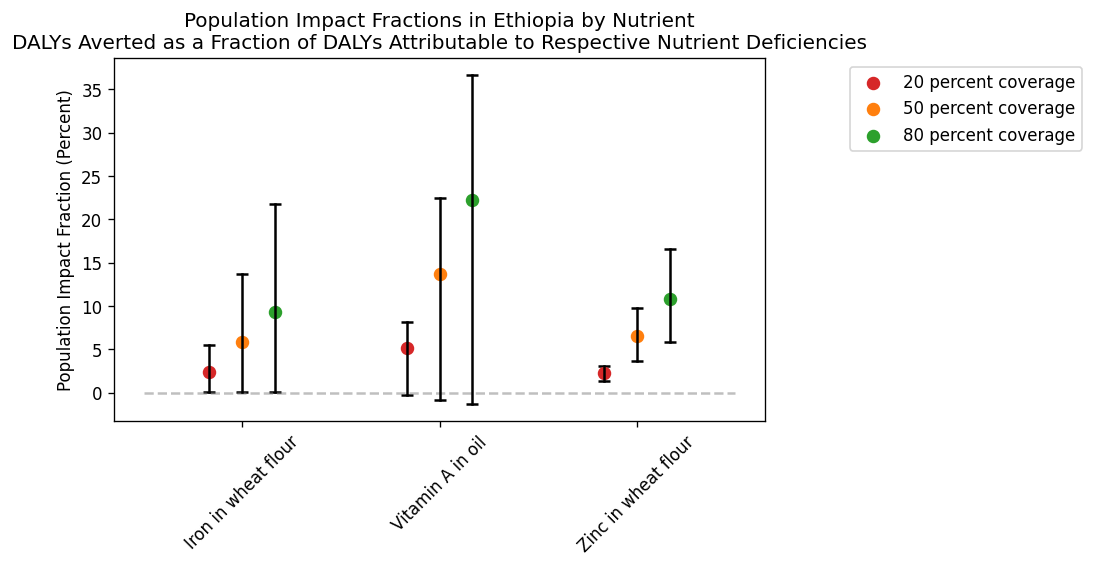

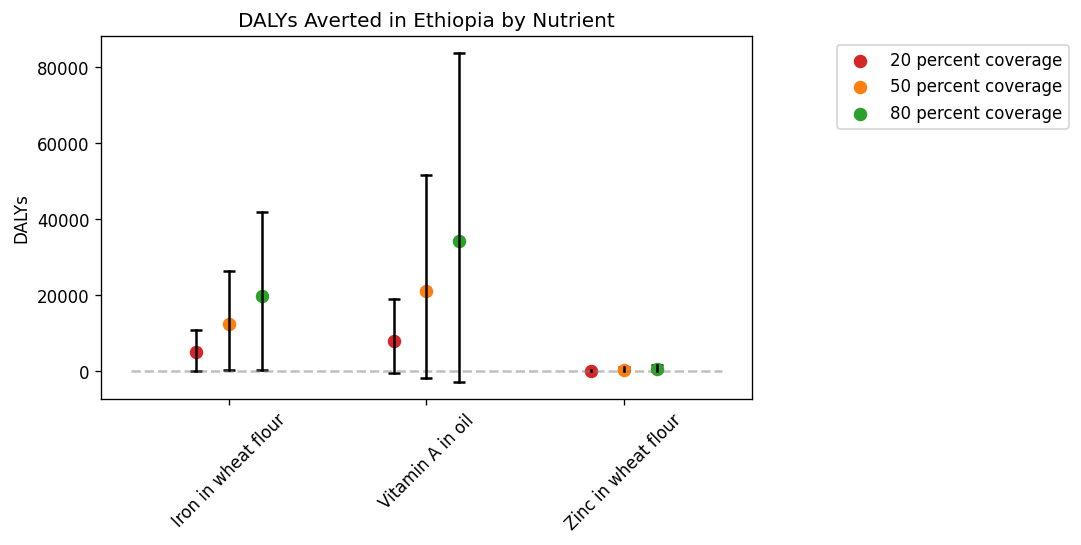

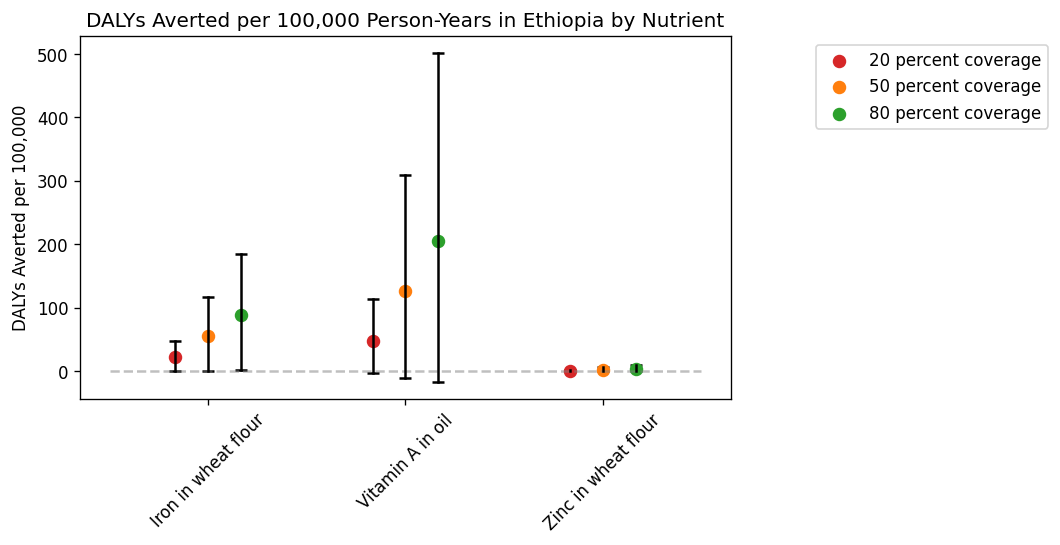

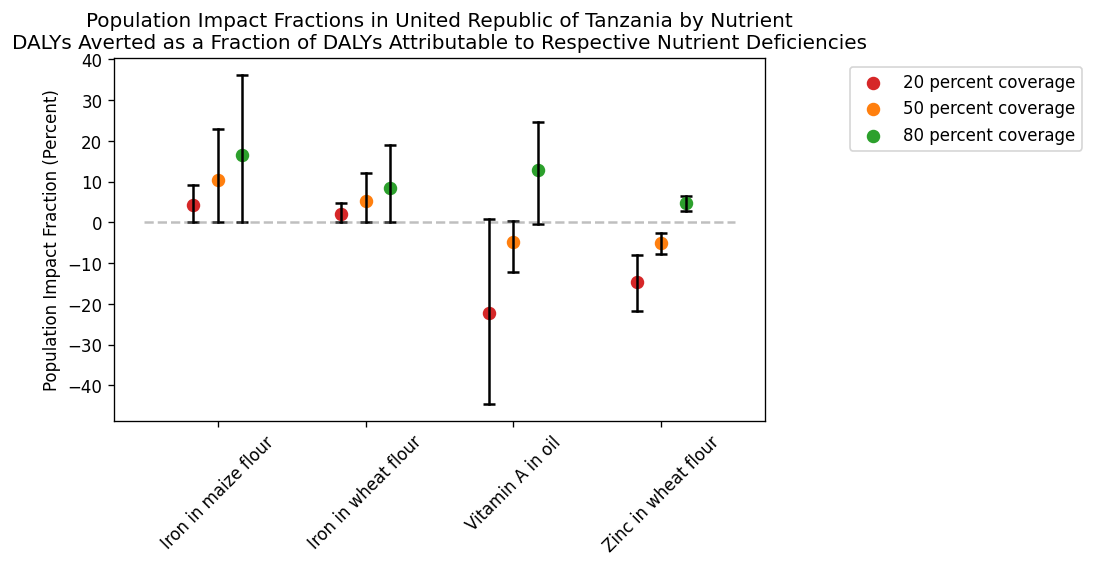

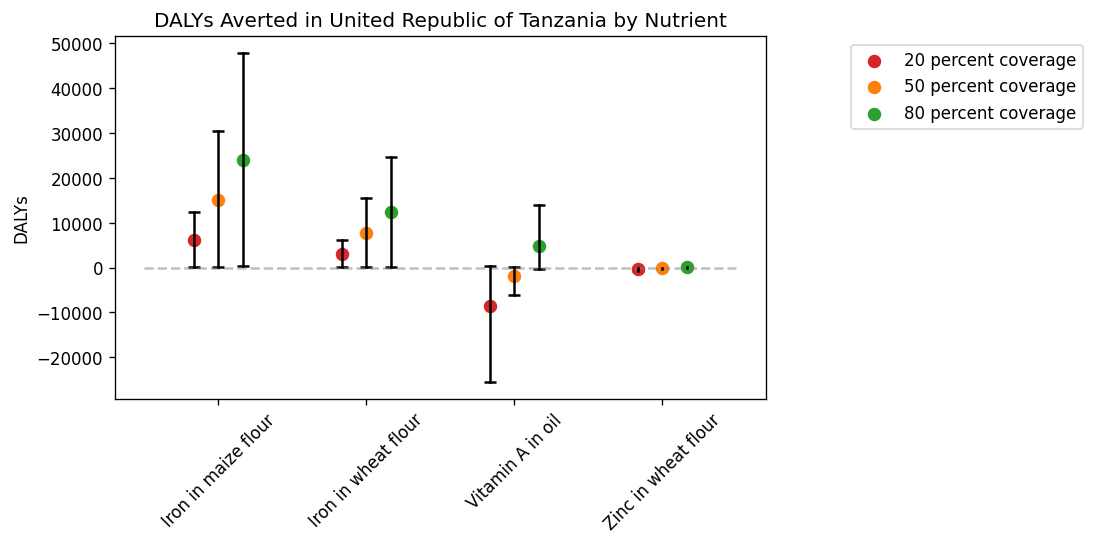

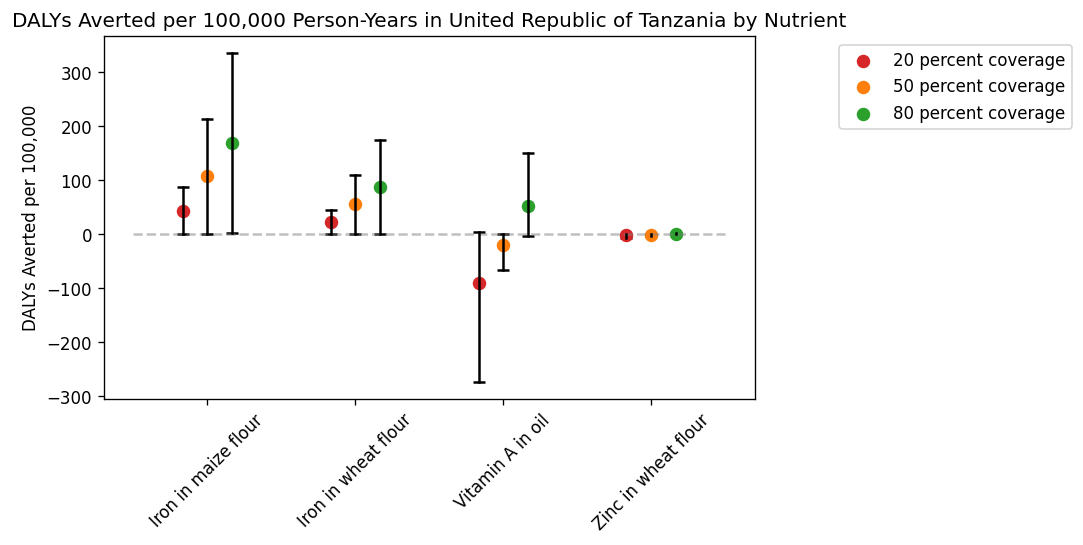

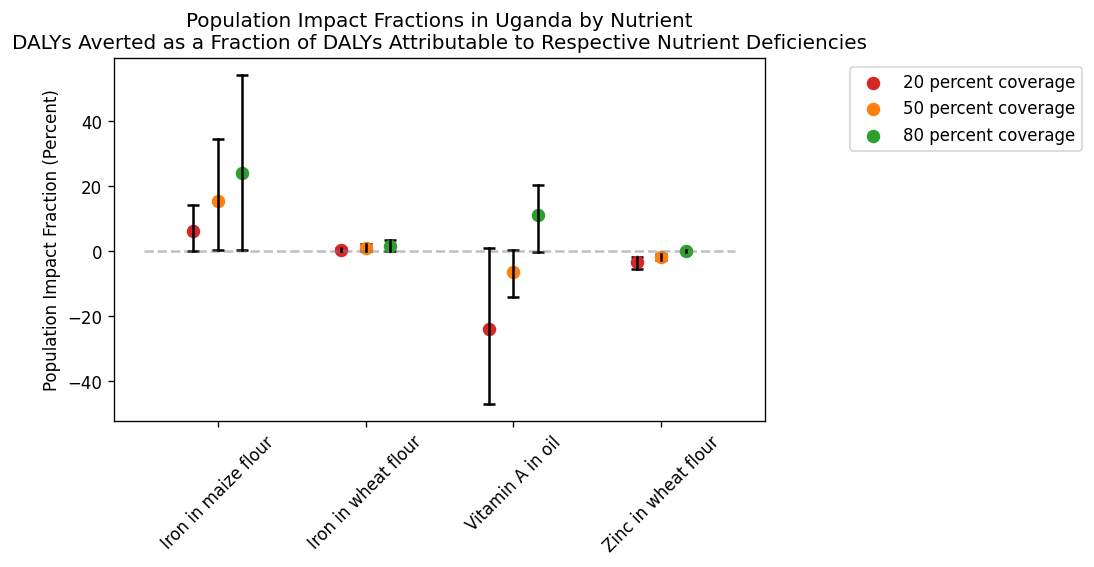

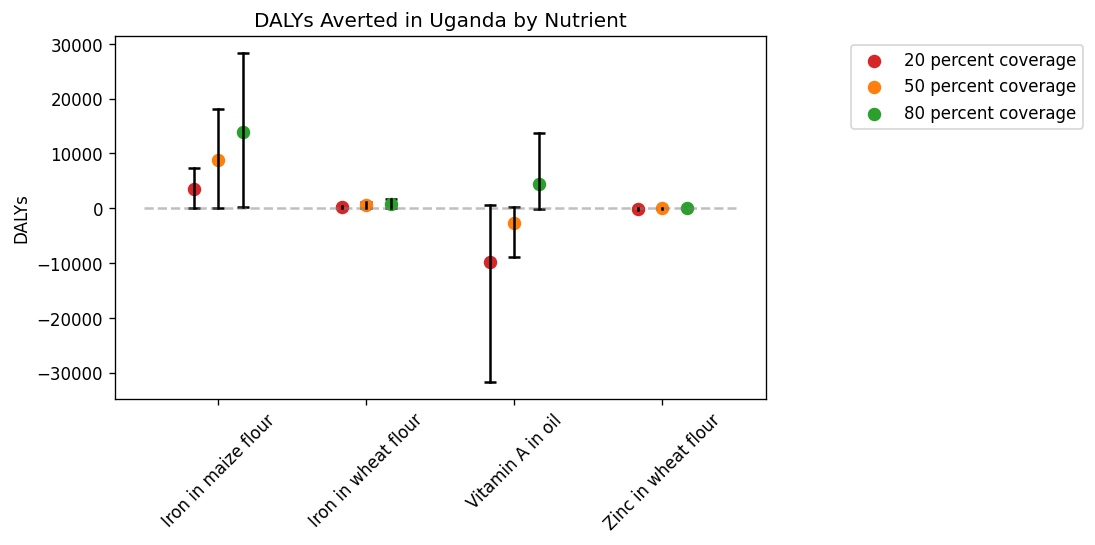

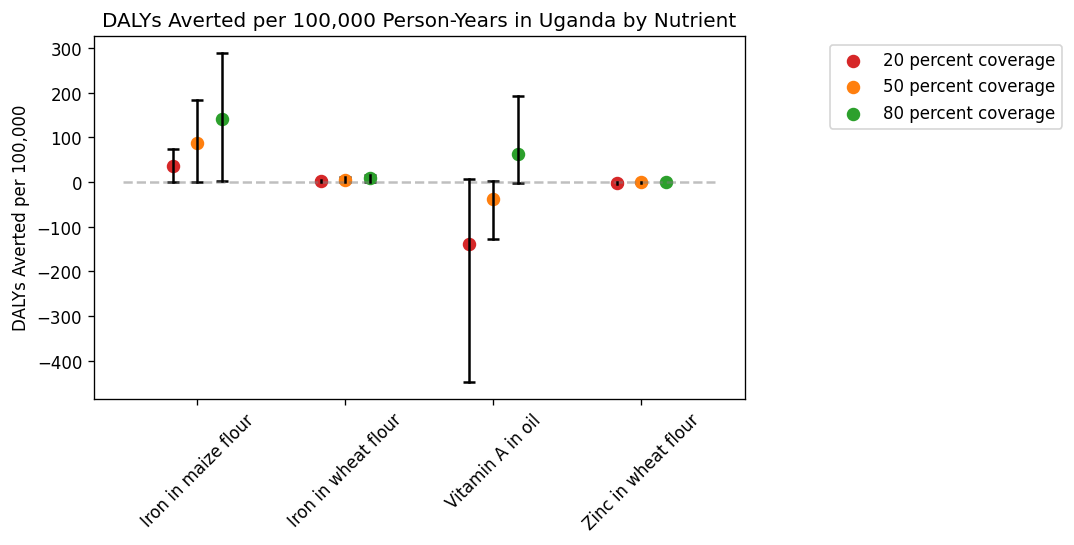

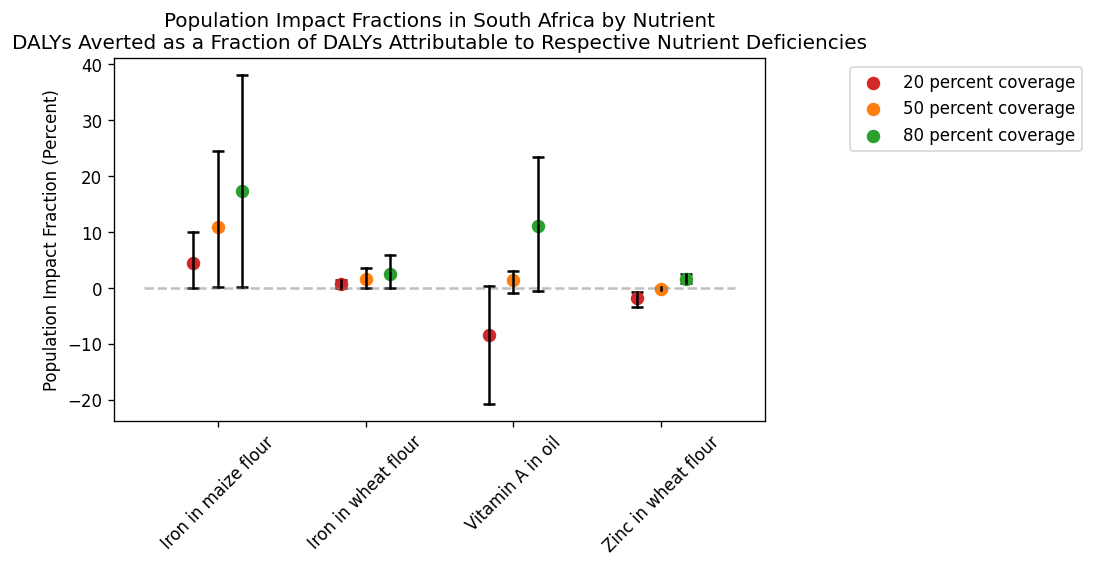

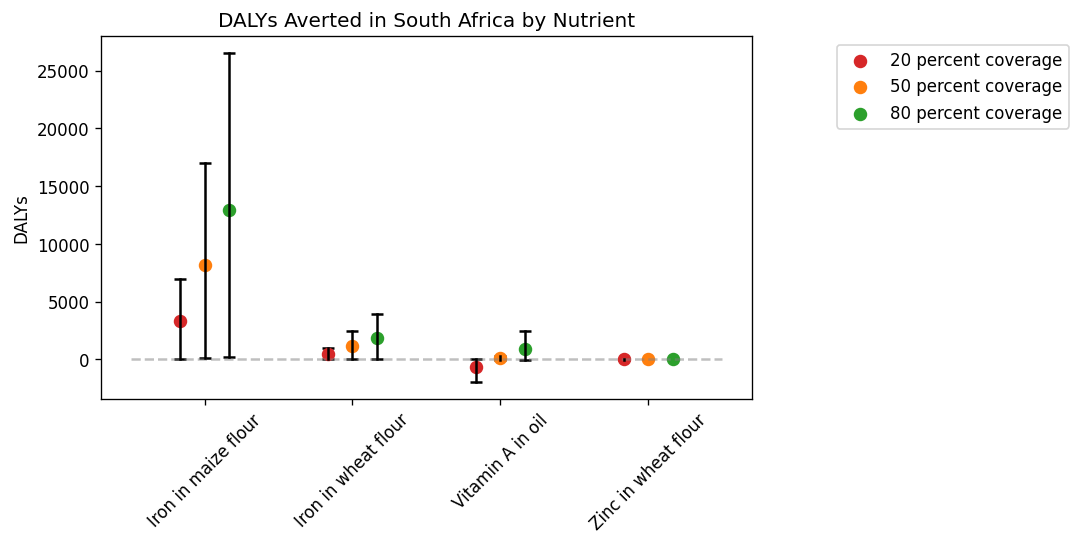

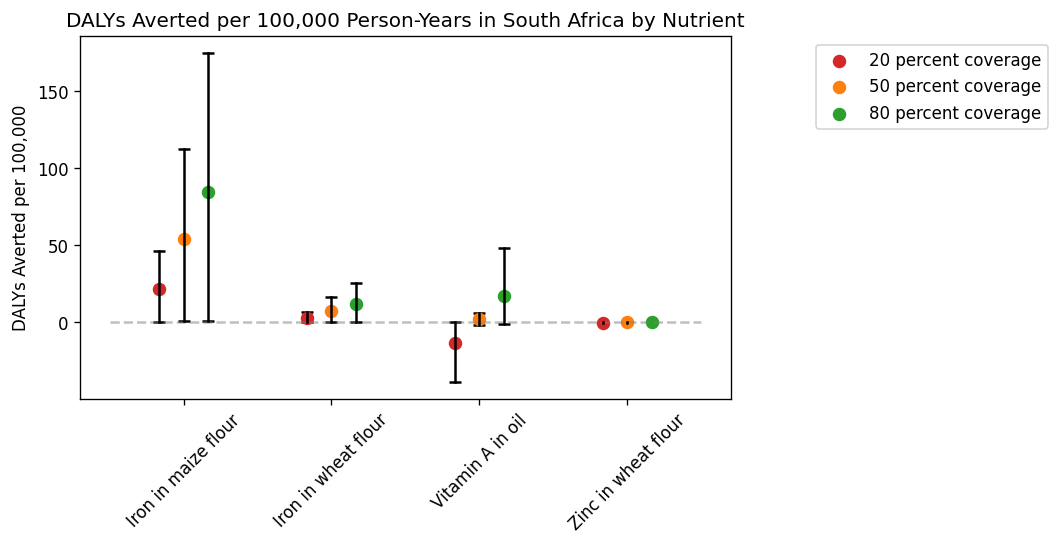

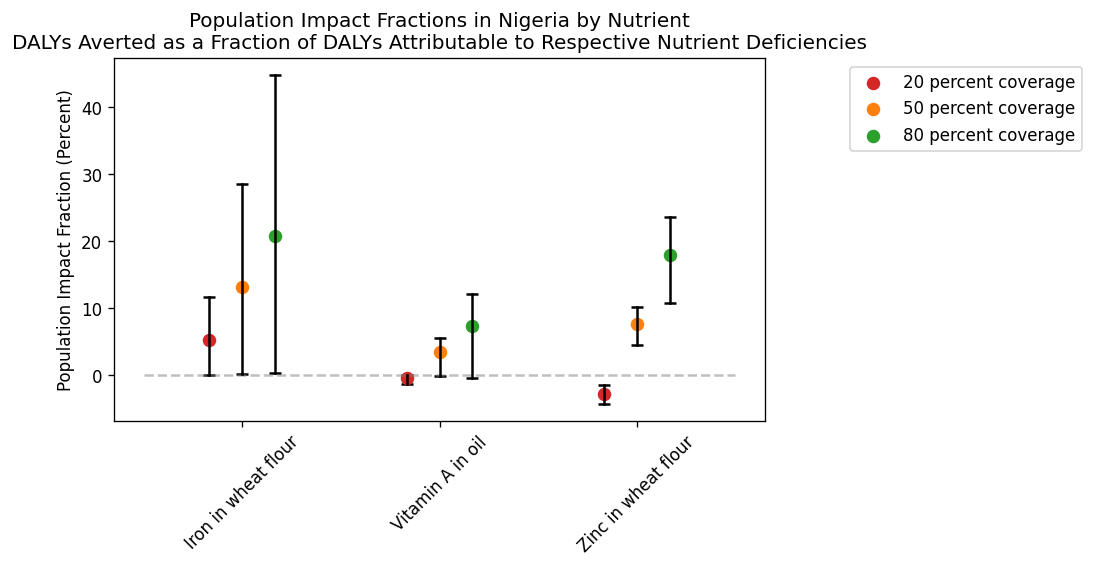

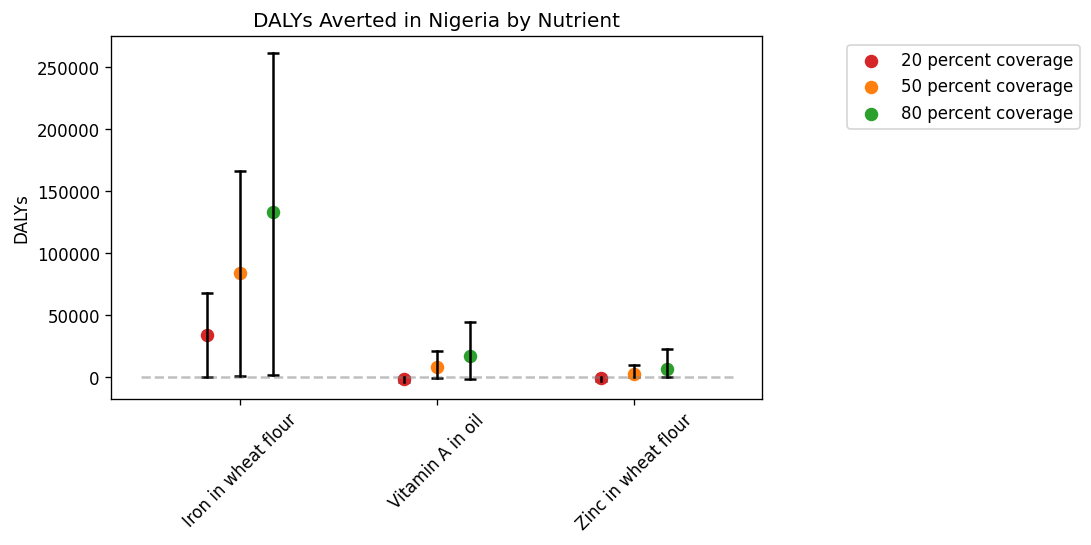

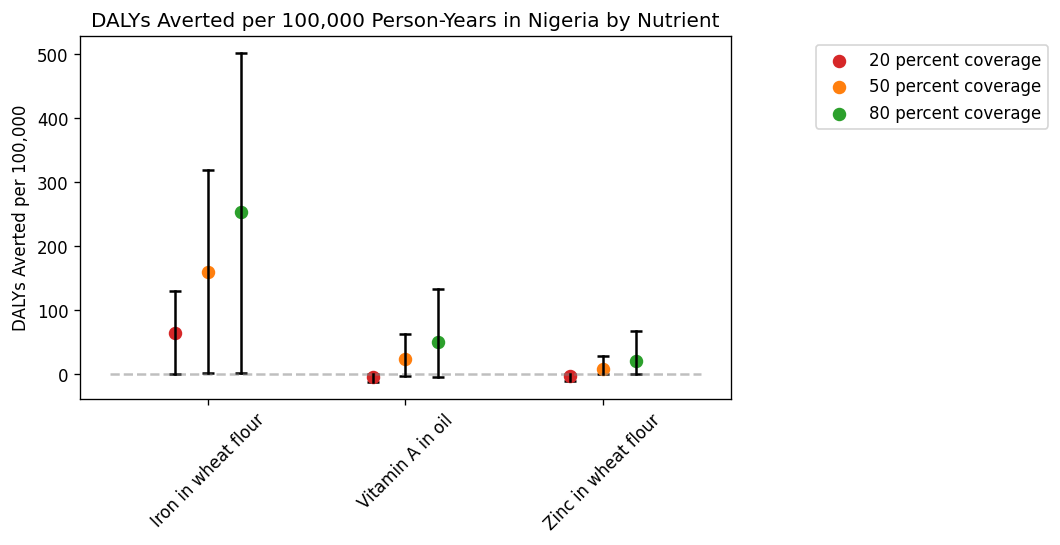

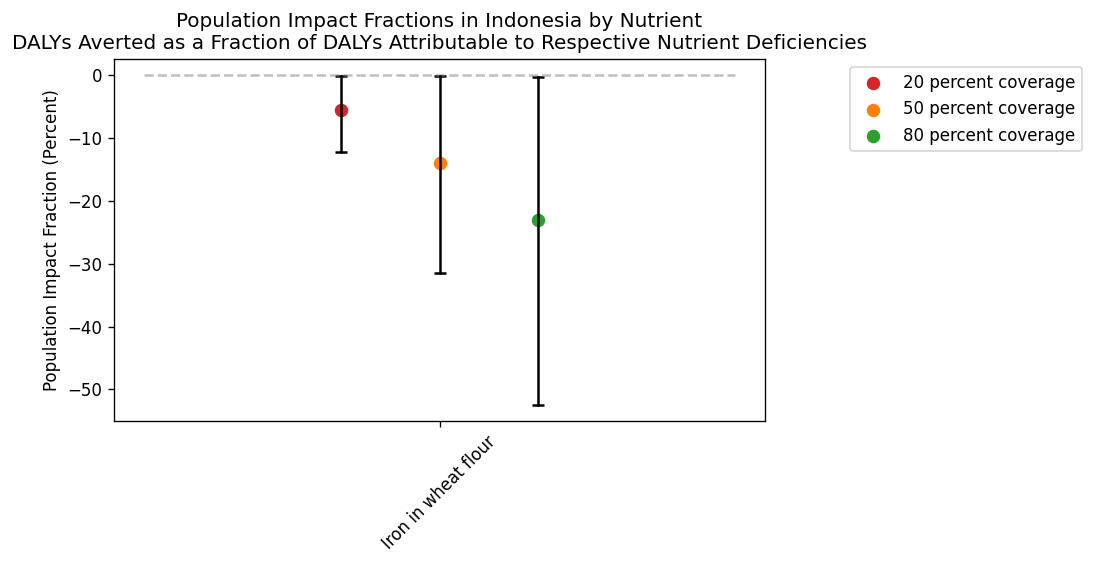

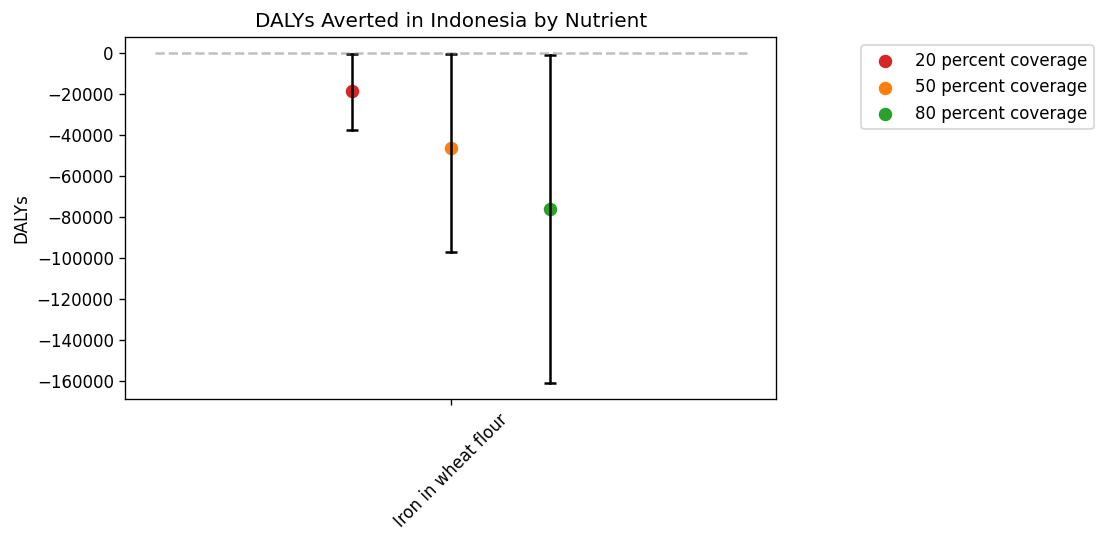

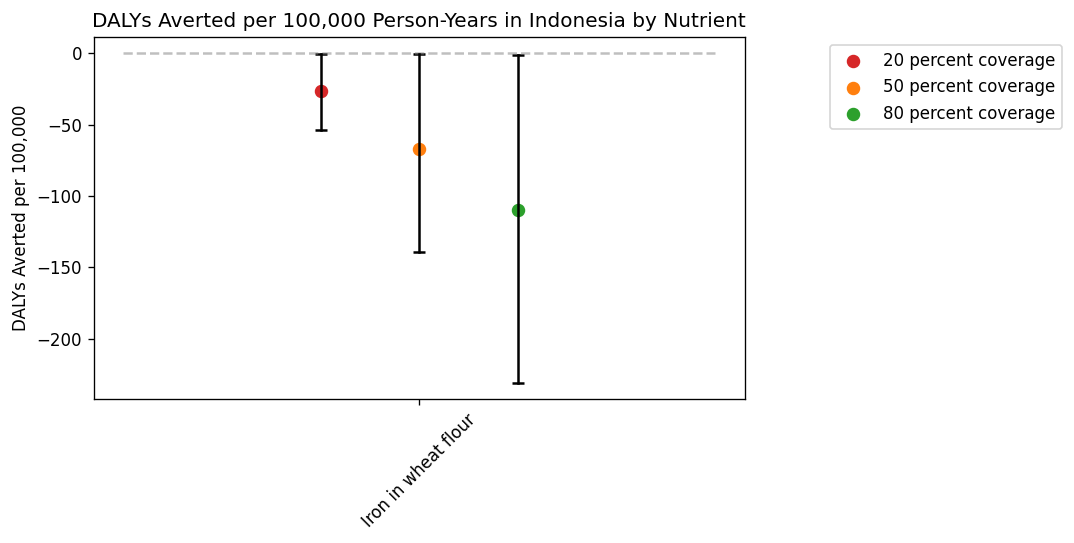

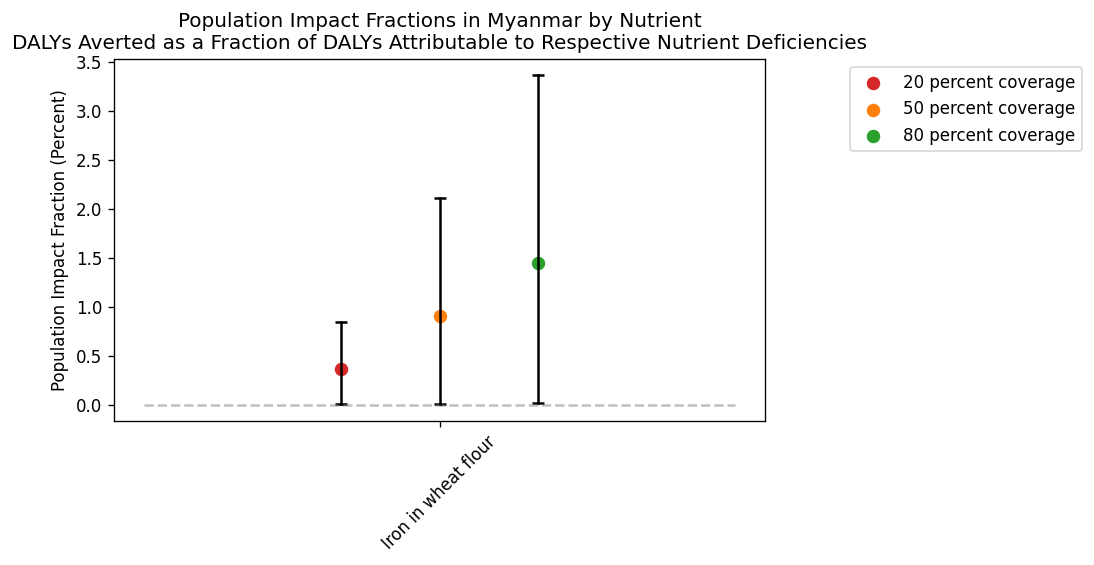

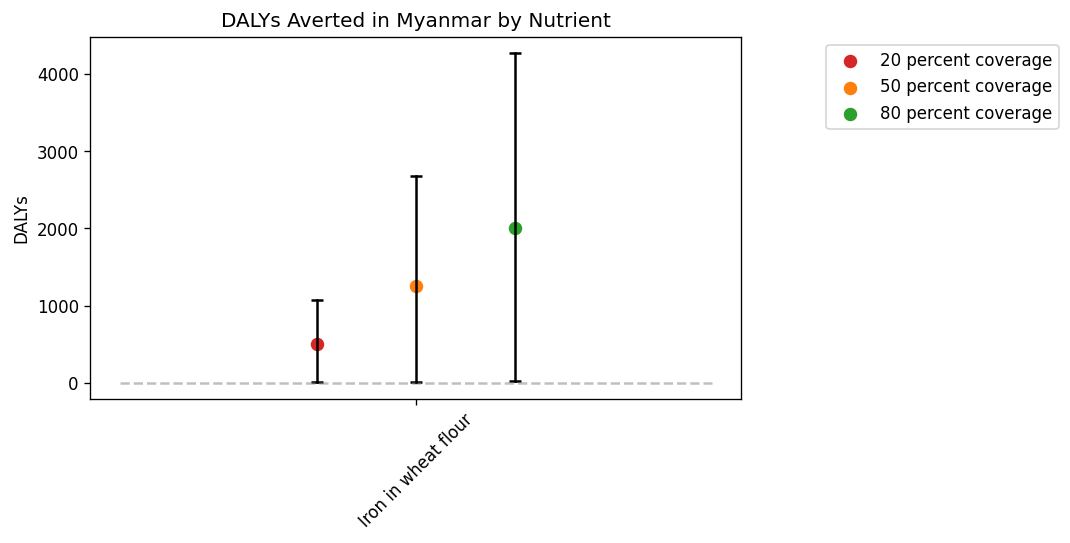

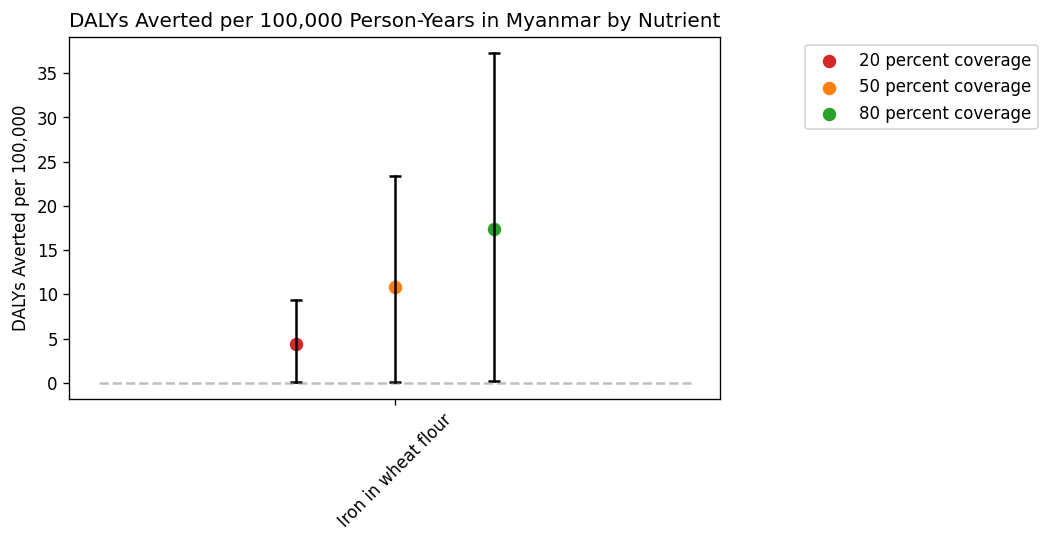

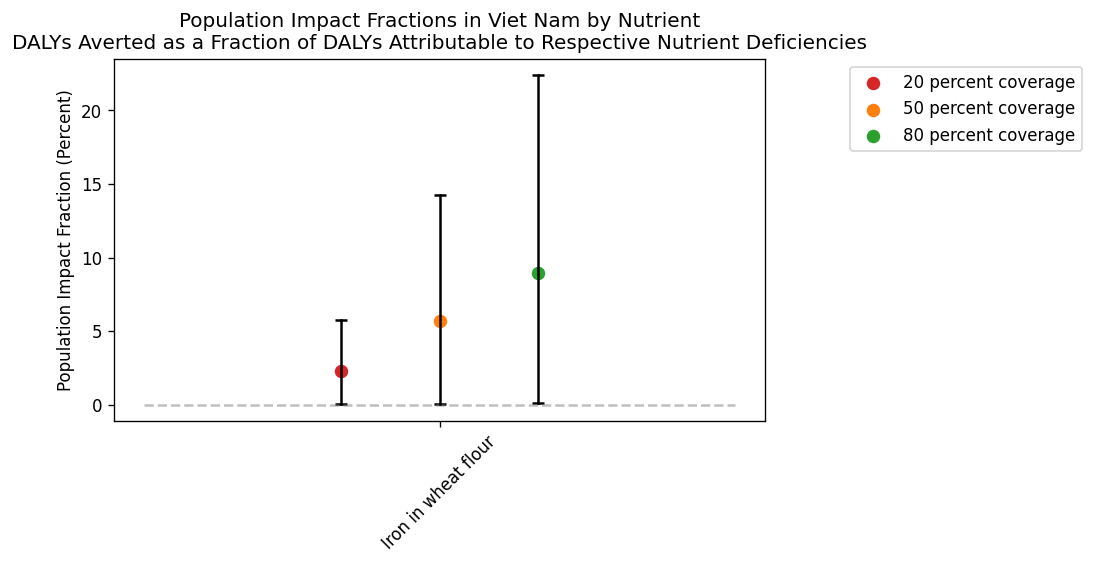

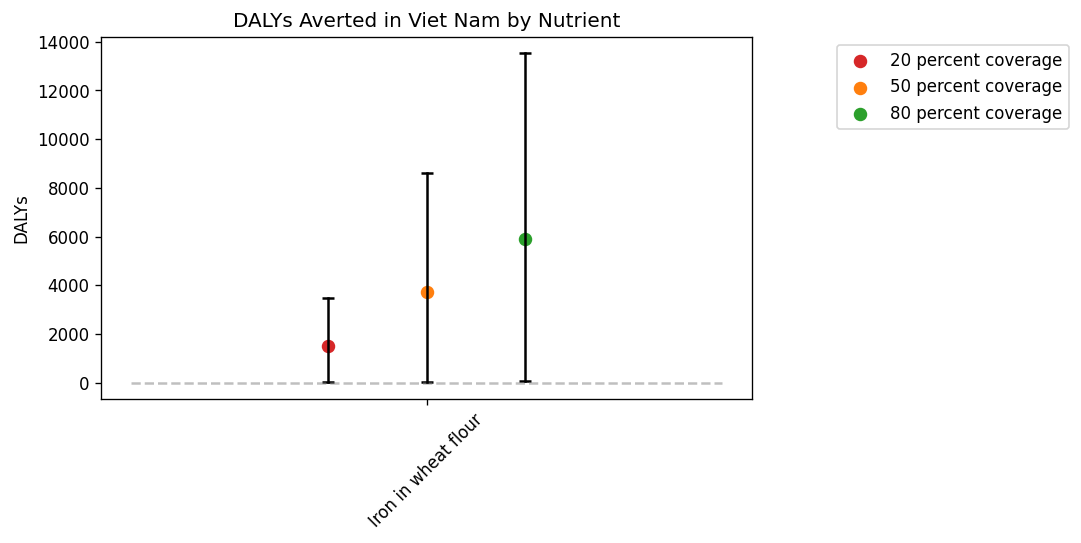

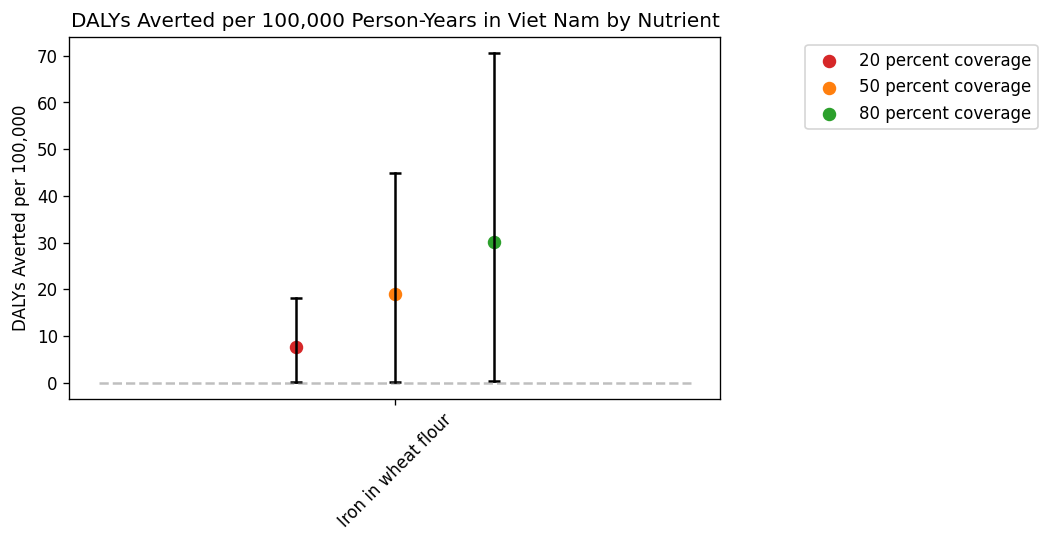

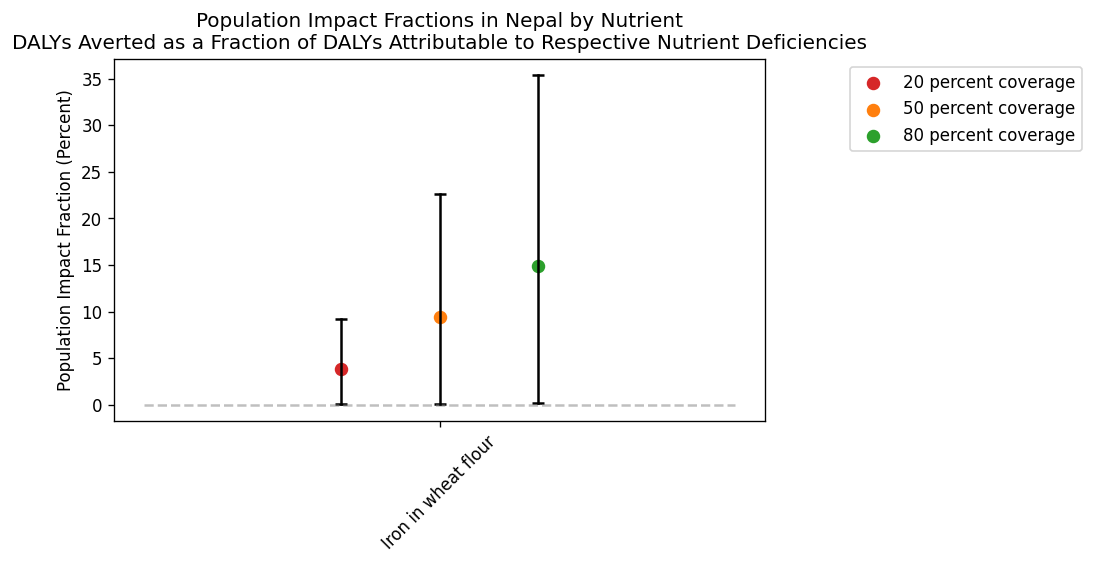

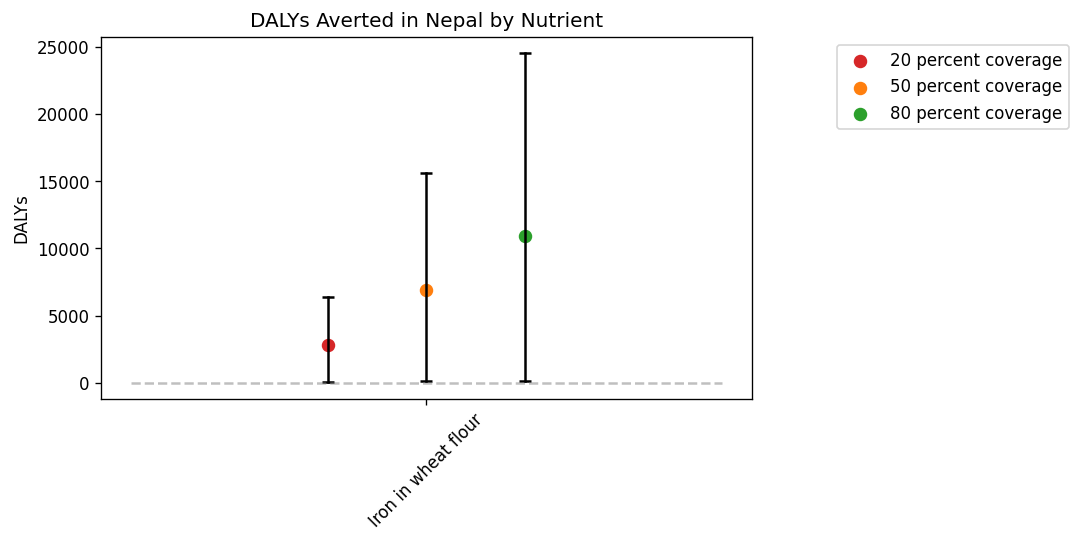

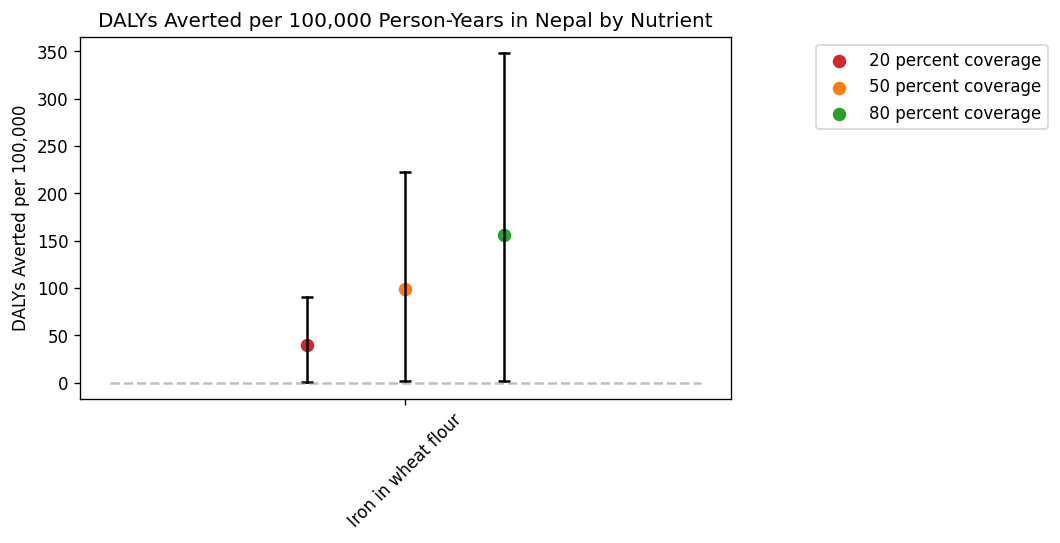

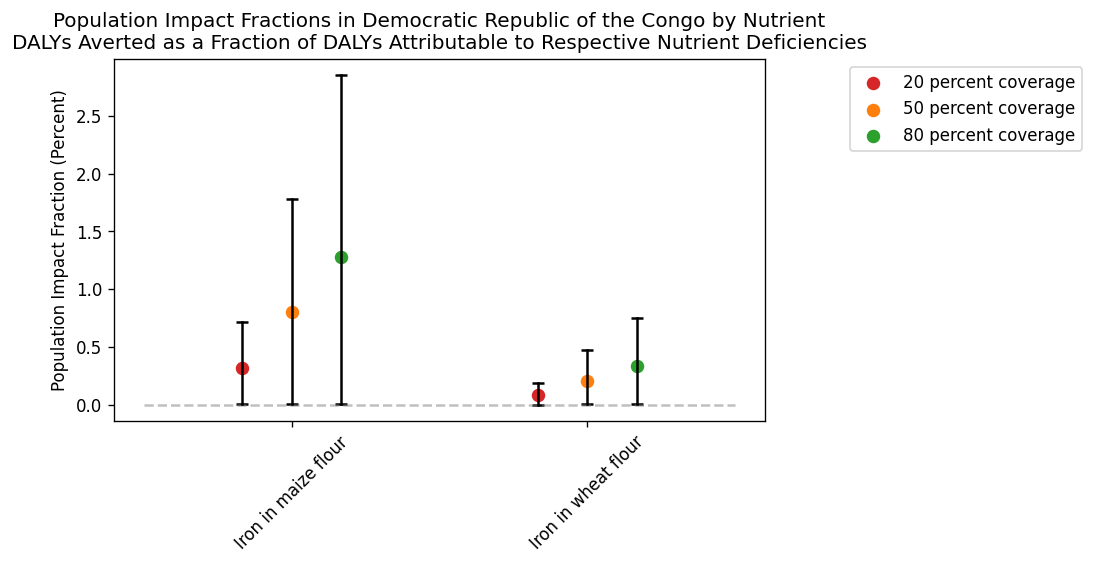

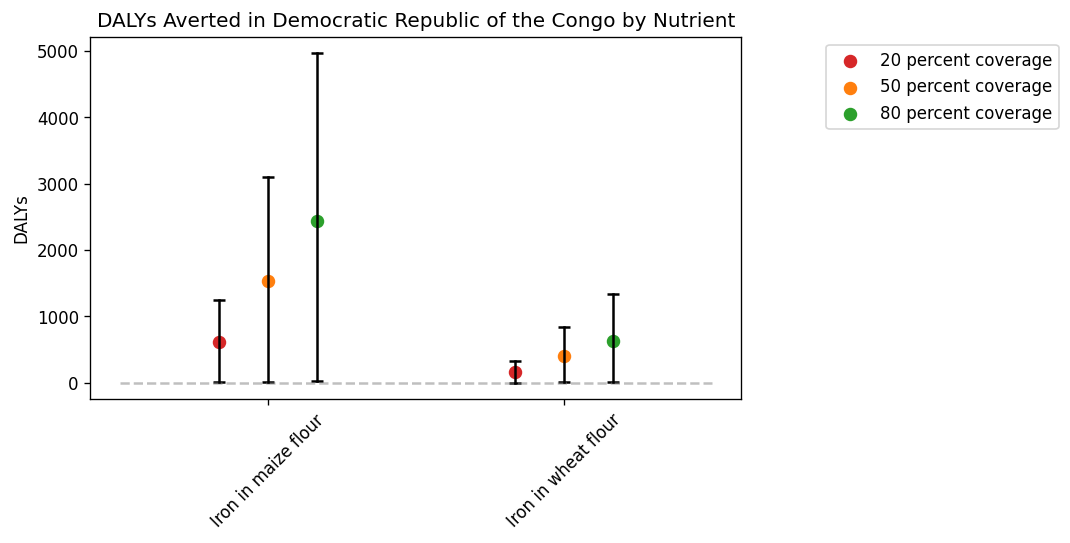

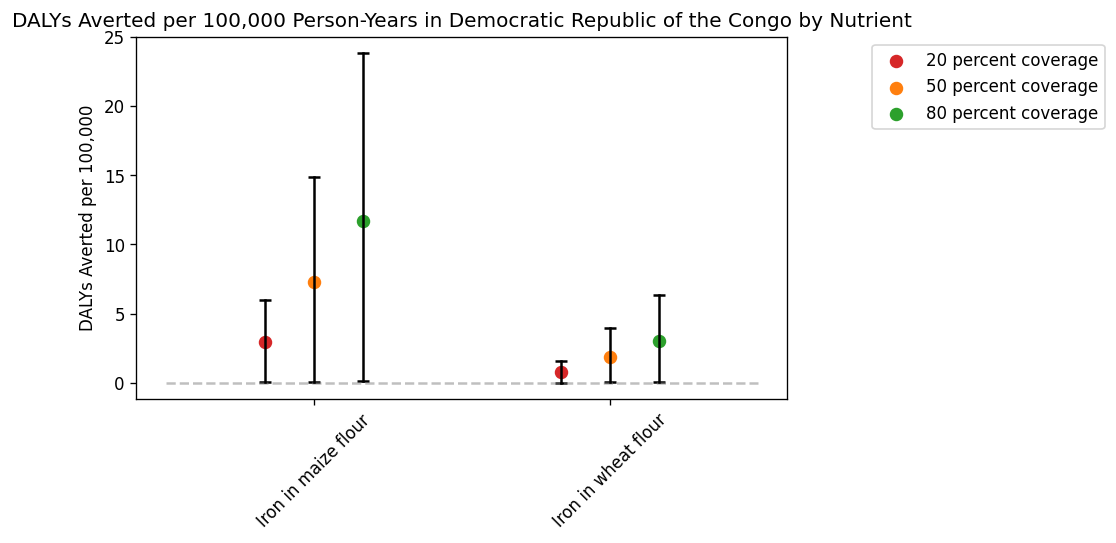

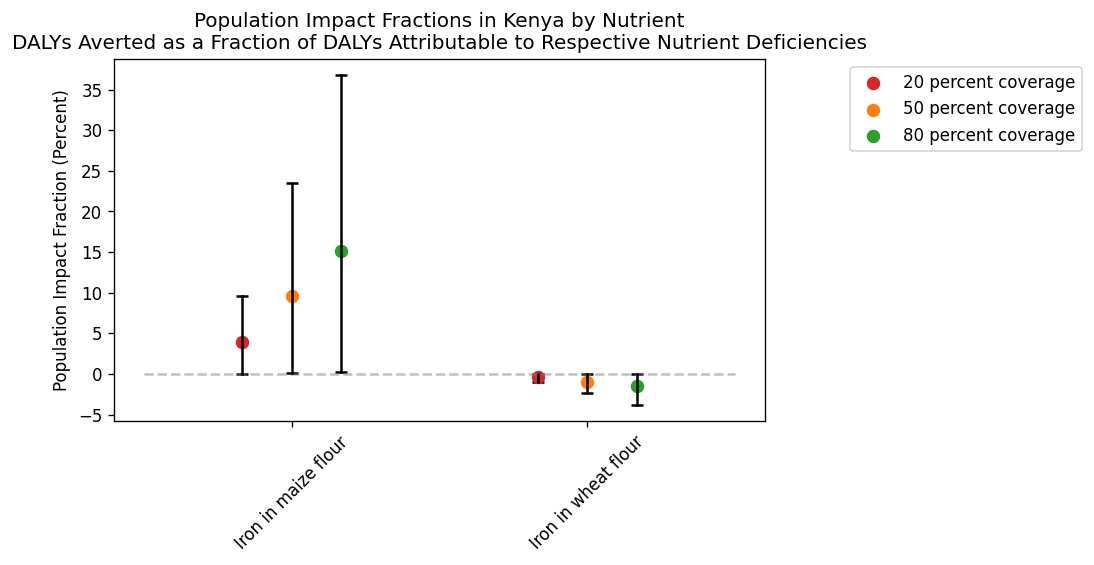

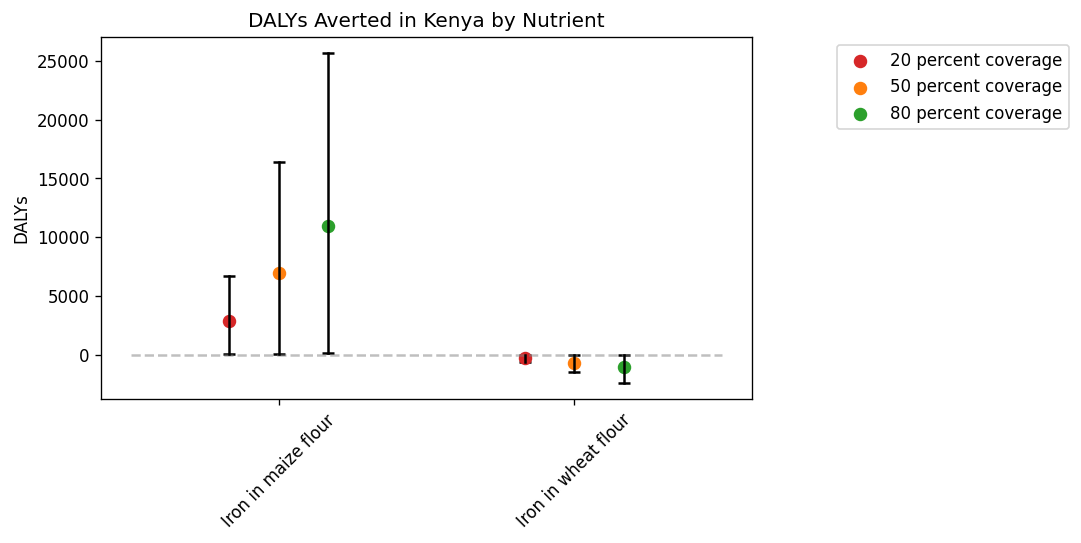

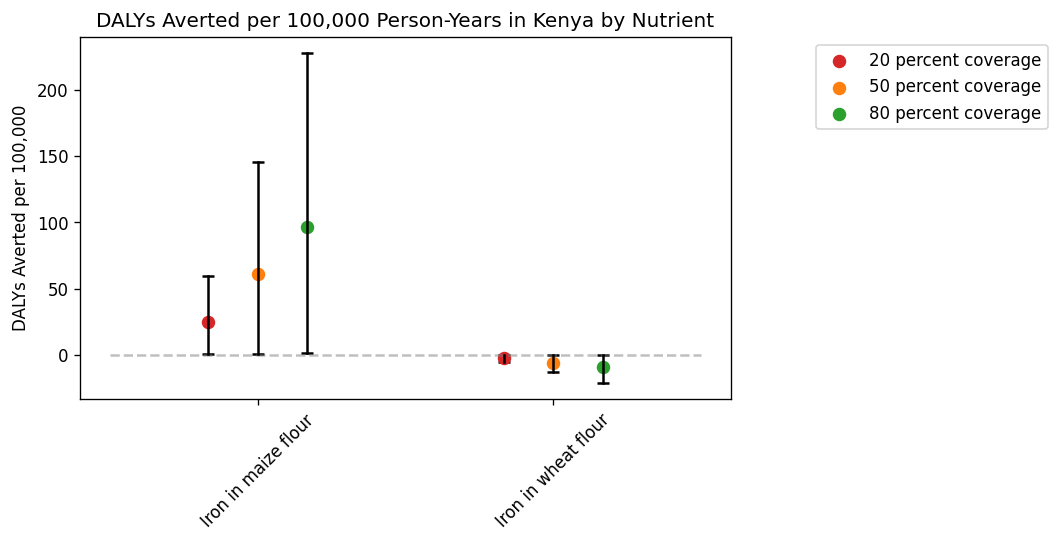

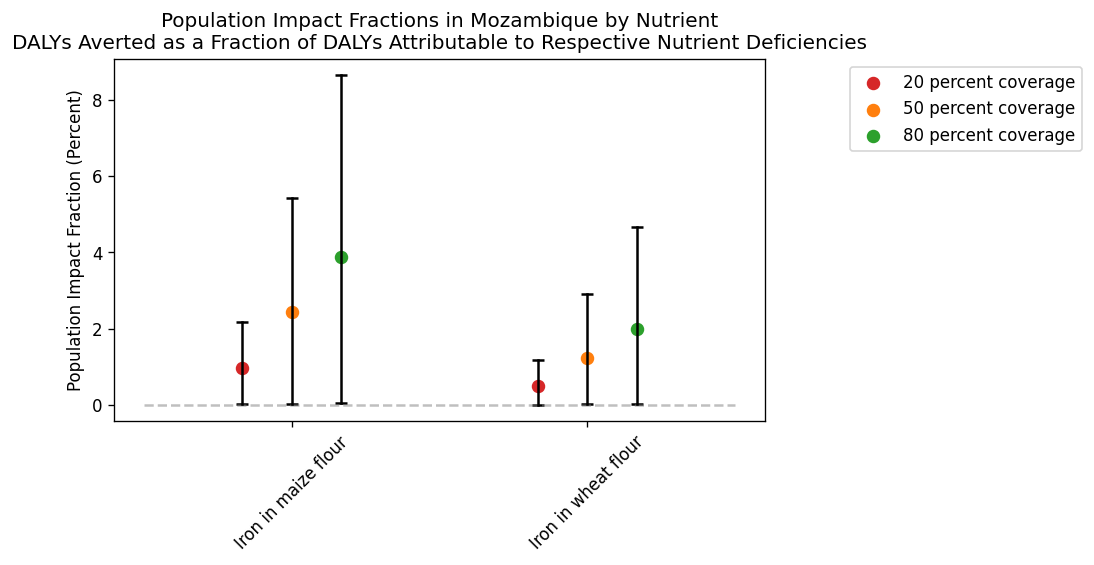

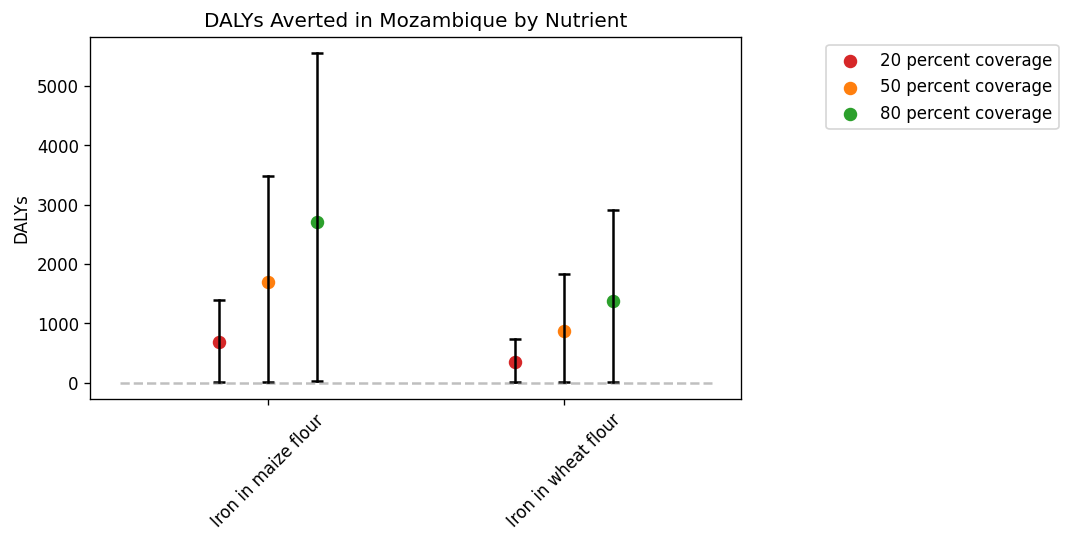

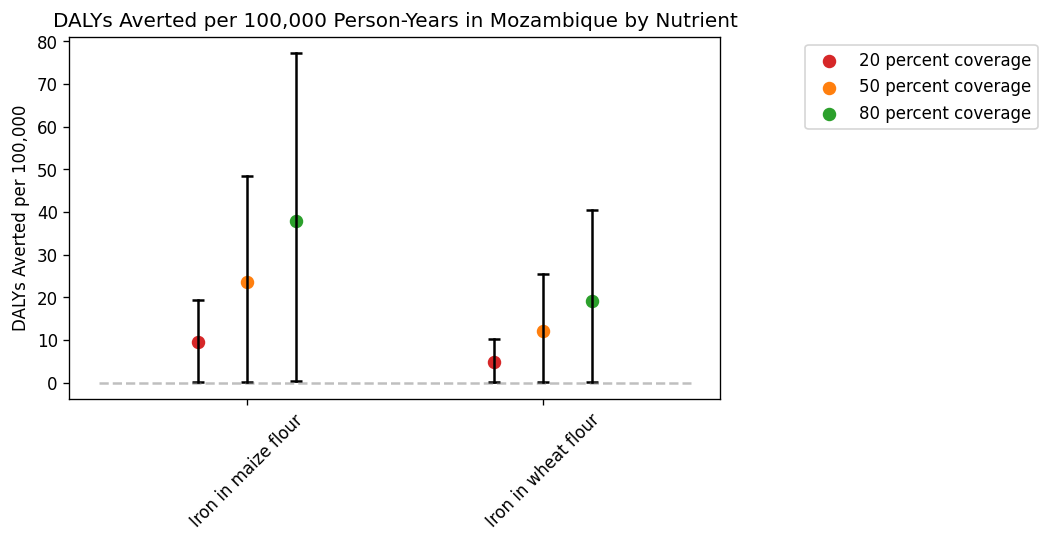

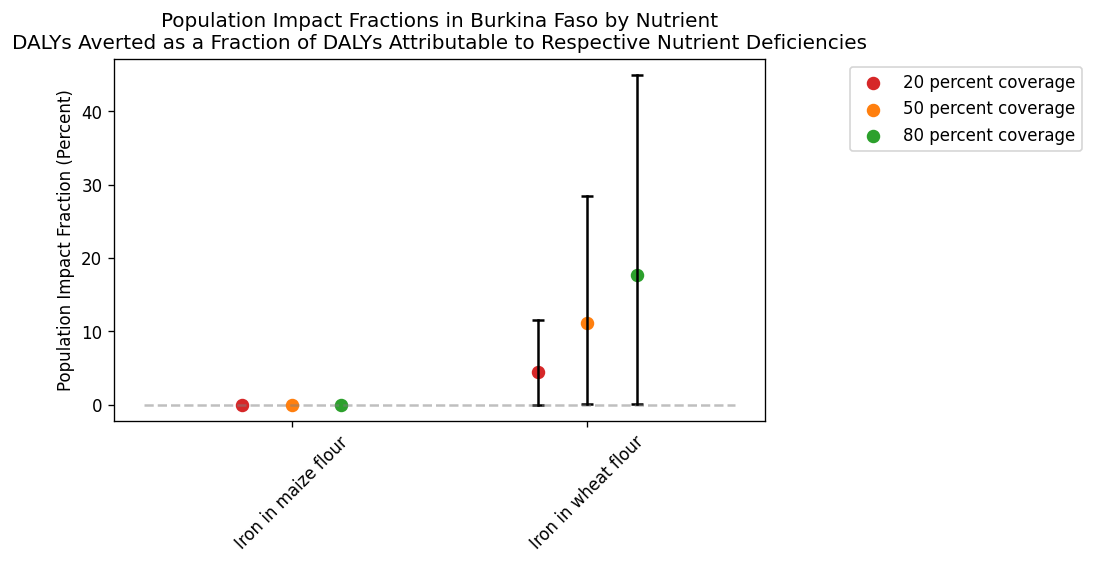

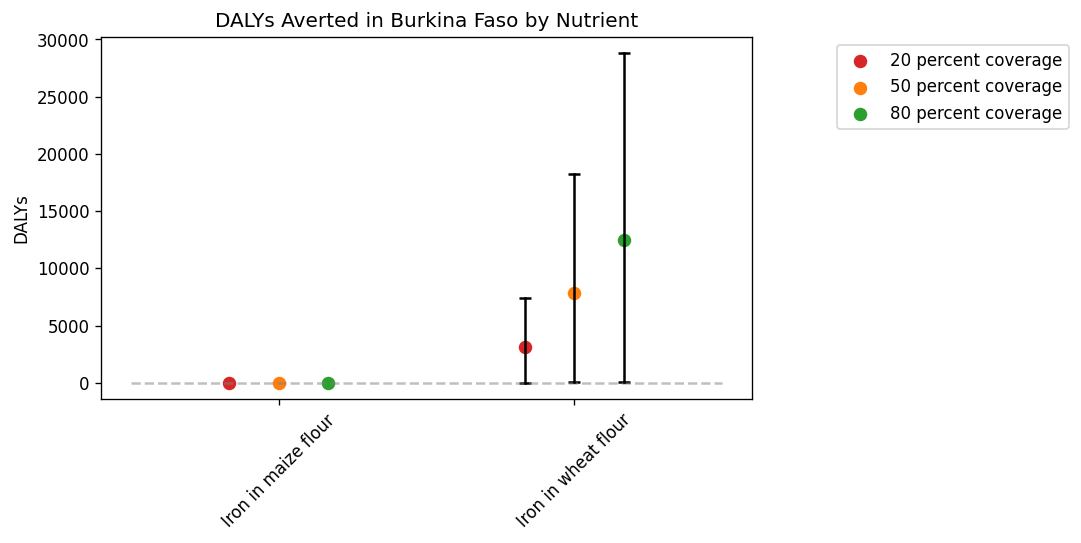

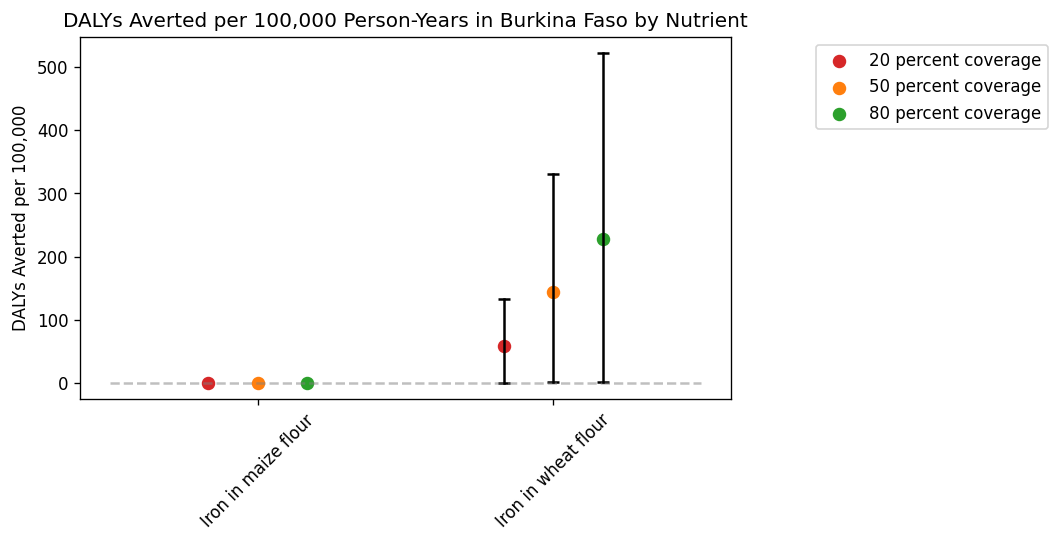

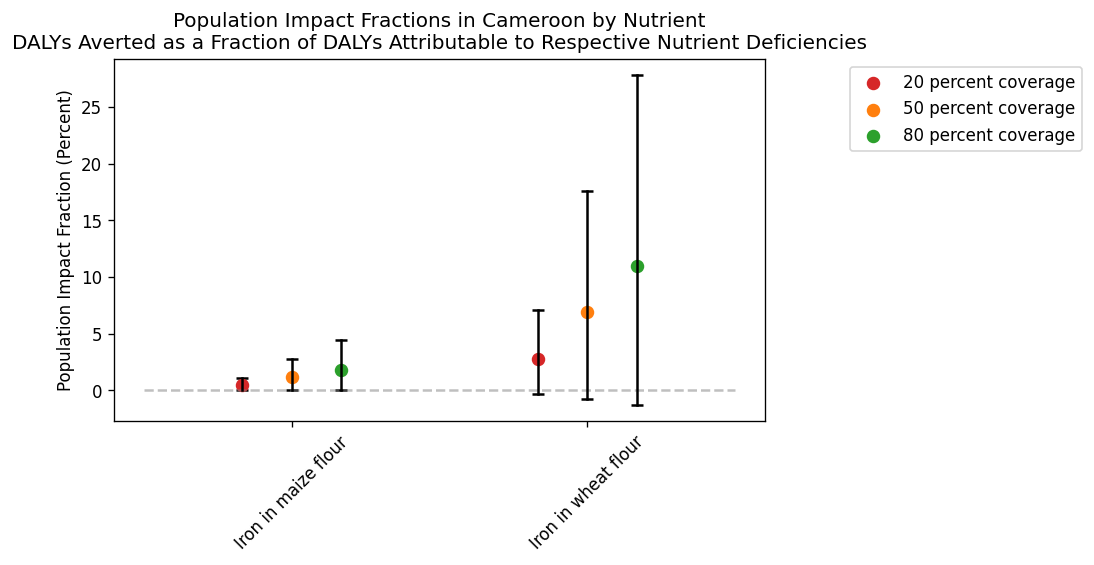

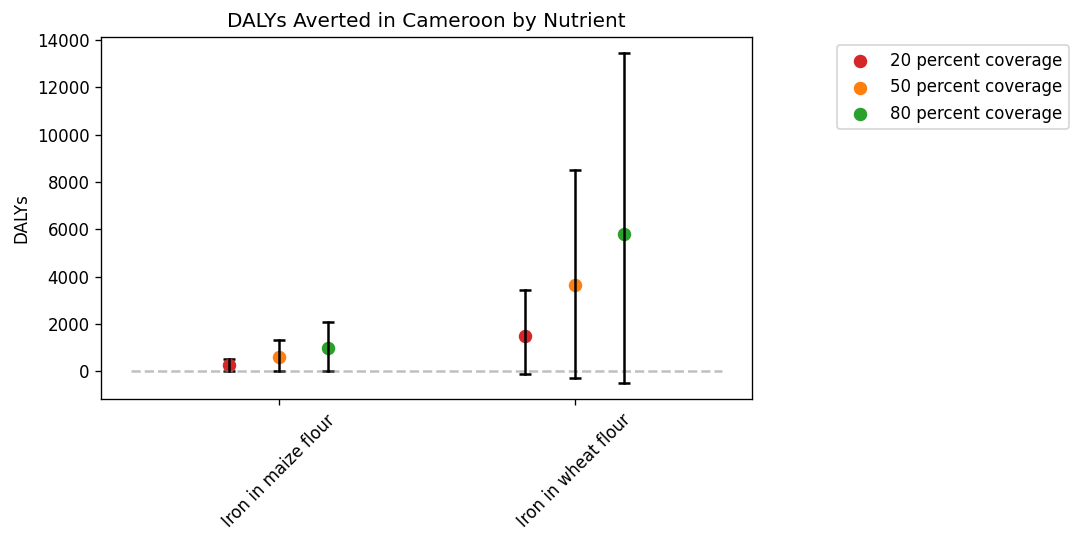

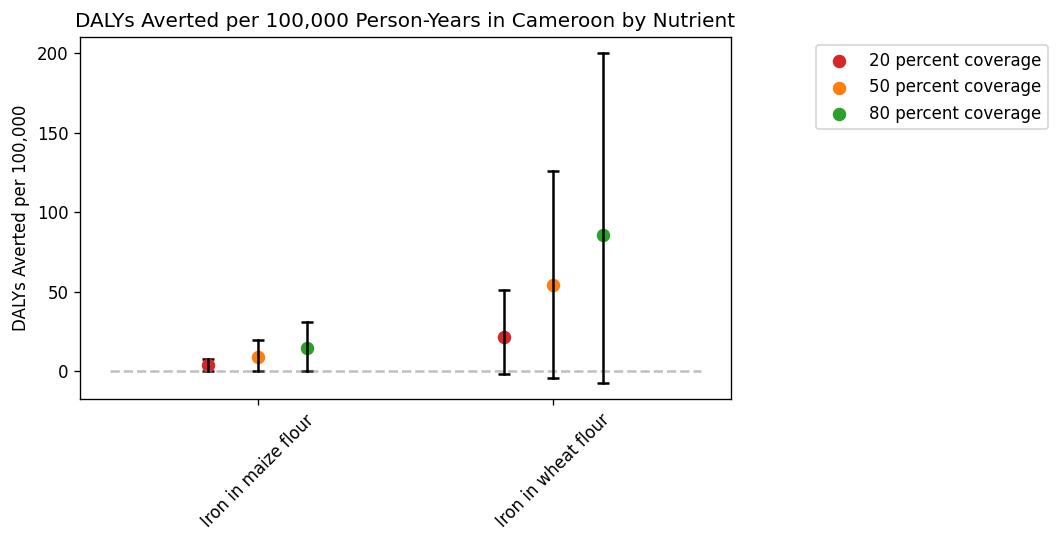

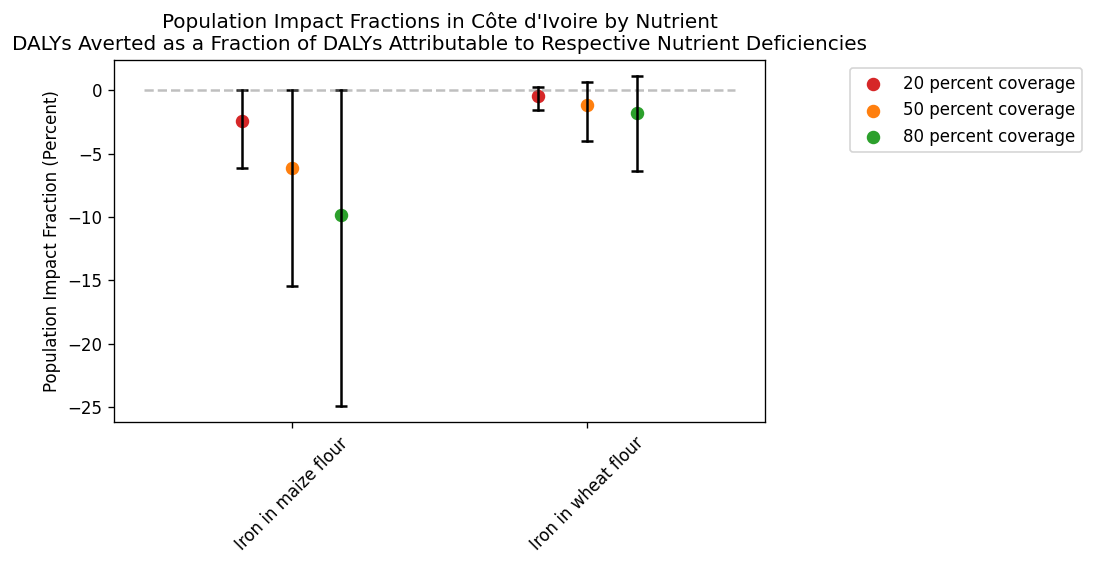

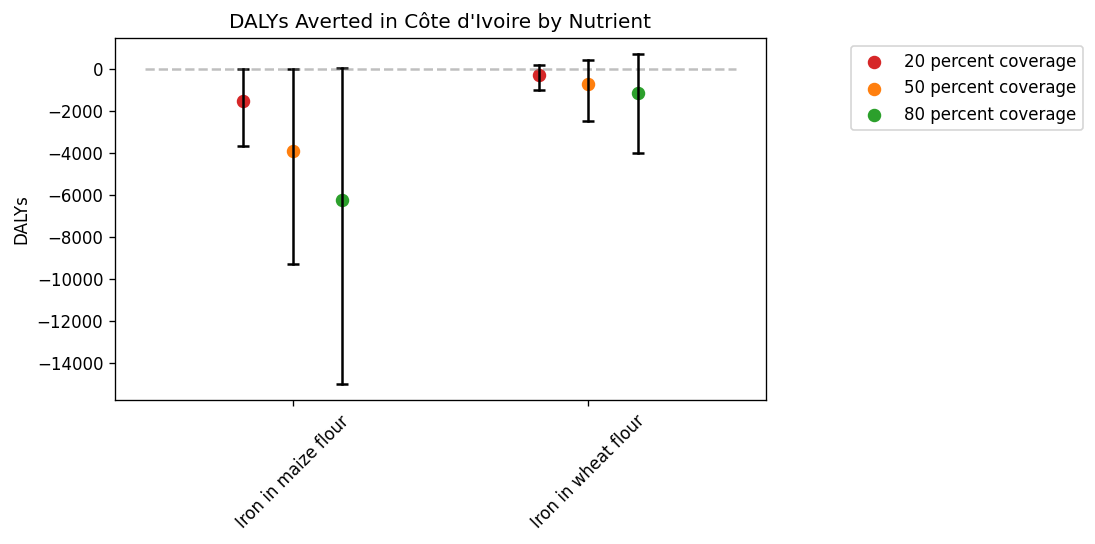

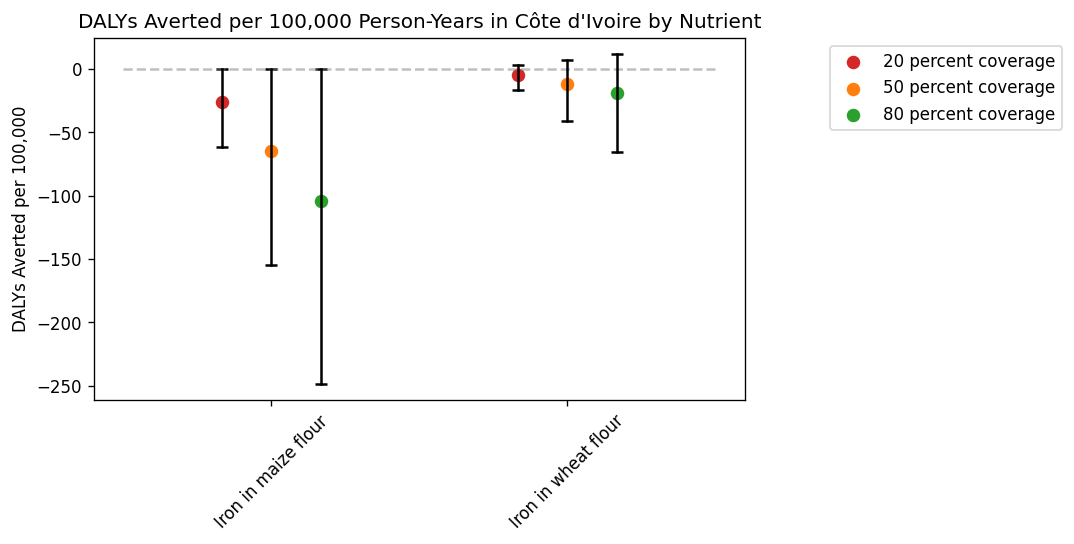

In [64]:
for location_id in results.location_id.unique():
    for measure in ['pif','counts_averted','rates_averted']:
        make_location_specific_plots(results, location_id, measure, coverage_levels)